# **다음 분기에 어떤 게임을 설계해야 할까?**
---
**사전 파악할 내용**  

* 지역에 따라서 선호하는 게임 장르가 다른지  
* 연도별 게임의 트렌드가 있는지  
* 출고량이 높은 게임에 대한 분석 및 시각화 프로세스  
---
**목표 달성 방향성**  


* 지역 및 연도를 통한 트랜드의 방향을 파악하고, 지속적으로 출고량이 높은(인기있는) 게임을 출시하는 방향으로 분석할 예정.

---
**처리 순서**  

1. 데이터셋 불러오기
2. 결측치 확인 및 제거
3. 이상치 확인 및 제거
4. Scaling 
5. feature engineering 통해 사전내용 파악
6. 예측 및 해석

---


### **데이터 셋 불러오기**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving vgames2.csv to vgames2.csv


In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(io.StringIO(uploaded['vgames2.csv'].decode('utf-8')))
del df['Unnamed: 0']

# df.shape  (16598, 9)

In [ ]:
# 한글 깨짐 현상 제거
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (32.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155455 files and di

### **데이터 결측치 확인**

In [ ]:
#df.isnull().sum()       # 결측치 확인 (Year :271, Genre :50, Publisher :58)
#df.info()               # 데이터 타입 확인, Year=float, 그 외 = object     -> Year과 출고량은 dtype 변경 필요


# raw_data를 살펴보니 Publisher value 중 'Unknown'이 있음을 확인.
# Publisher의 결측치는 Unknown으로 변경 예정
# Year, Genre 결측치는 제거

**결측치 제거**

In [ ]:
df.dropna(subset=['Genre', 'Year'], axis=0, inplace=True)           # Genre, Year : 결측치 행 삭제함
df.fillna({'Publisher':'Unknown'}, inplace=True)                    # 결측치 대체

# df.shape   (16277, 9)  : 321개의 row가 삭제됨. 전체의 2% 정도이므로 전체 data에 영향이 없다고 판단함!

### **이상치 확인**

1. Year dtype 변경
1. Year 이상치 수정
1. Sales dtype 변경
 

**Year dtpye 변경**

In [ ]:
# Year : float -> int
df['Year'] = df['Year'].round(0).astype(int)

**Year 이상치 수정**  
: raw data에서 1~99사이의 숫자가 존재하는 것을 확인함

In [ ]:
def fix_Y(x):
    if x >= 0 and x <= 20:
        x = x + 2000
    elif x >= 21 and x <= 99:
        x = x + 1900
    else:
        x
    return x

df['Year'] = df['Year'].apply(fix_Y)

**Sales dtype 변경**

In [ ]:
# Sales : object -> float
# value 사이에 K, M이 확인됨. K=1, M=0.001로 계산

def tofloat(x):
    if x[-1] == 'K':
        x = float(x.replace('K', '')) / 1000
    elif x[-1] == 'M':
        x = float(x.replace('M', '')) / 1000000
    else:
        x
    return x

df['NA_Sales'] = df['NA_Sales'].apply(tofloat).astype(float)
df['EU_Sales'] = df['EU_Sales'].apply(tofloat).astype(float)
df['JP_Sales'] = df['JP_Sales'].apply(tofloat).astype(float)
df['Other_Sales'] = df['Other_Sales'].apply(tofloat).astype(float)

In [ ]:
# float로 바뀐 sales 값을 더해서 Total_Sales column 생성
df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

**중복 데이터 확인**

In [ ]:
# 중복값 확인 후 제거

df.duplicated().sum()        # 중복값 확인 결과 :0
#df.drop_duplicates()

0


---

데이터 중간 점검!

In [ ]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [ ]:
df.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
count,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000
mean,2006.407630,0.262304,0.146023,0.077353,0.047909,0.533589
std,5.828646,0.815212,0.506386,0.306786,0.189402,1.549215
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000
max,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


요약 데이터프레임을 보니, 북미와 유럽의 출고량이 현저히 높은 것으로 보인다.  
다음 분기 게임을 출시 할 때는 **북미, 유럽을 타겟**으로 하면 좋을 듯 하다.  
(mean, std를 통해 확인 가능)

---


### **수출국가 현황**

In [ ]:
# 데이터셋

NA = df['NA_Sales'].sum()
EU = df['EU_Sales'].sum()
JP = df['JP_Sales'].sum()
Ot = df['Other_Sales'].sum()
Total = NA + EU + JP + Ot


df_area = [NA, EU, JP, Ot, Total]
df_area = pd.DataFrame(df_area)
df_area.index=['NA', 'EU', 'JP', 'Other', 'Total']
df_area = df_area.reset_index()
df_area.columns=['Area', 'Sales']

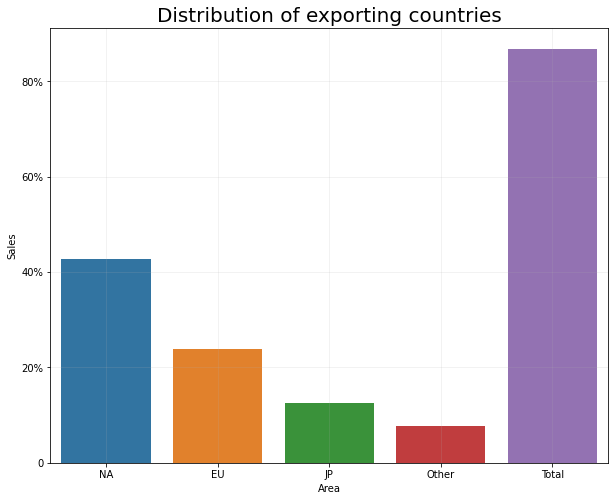

In [ ]:
plt.figure(figsize = (10, 8))
area = sns.barplot(data=df_area, x='Area', y='Sales')
area.grid(alpha=0.2)
area.set_yticklabels(['0', '20%', '40%','60%','80%'])
plt.title('Distribution of exporting countries', fontsize=20)
plt.show()

북미시장과 유럽시장이 규모가 큰 것을 알 수 있다.  
특히, **북미 시장은 전체의 40% 이상**을 차지하고 있음을 알 수 있다.

### **전체 시장에서 장르 선호도 파악**

In [ ]:
# 전체 출고량이 가장 높은 게임 장르 데이터셋
df1 = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Total_Sales']]
df1 = df1.melt(id_vars='Genre', value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Total_Sales'])
df1 = pd.crosstab(index=df1.Genre, columns=df1.variable, values=df1.value, aggfunc=sum).reset_index()

df1['Percentage'] = round(( df1['Total_Sales'] / df1['Total_Sales'].sum() ) * 100, 2)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


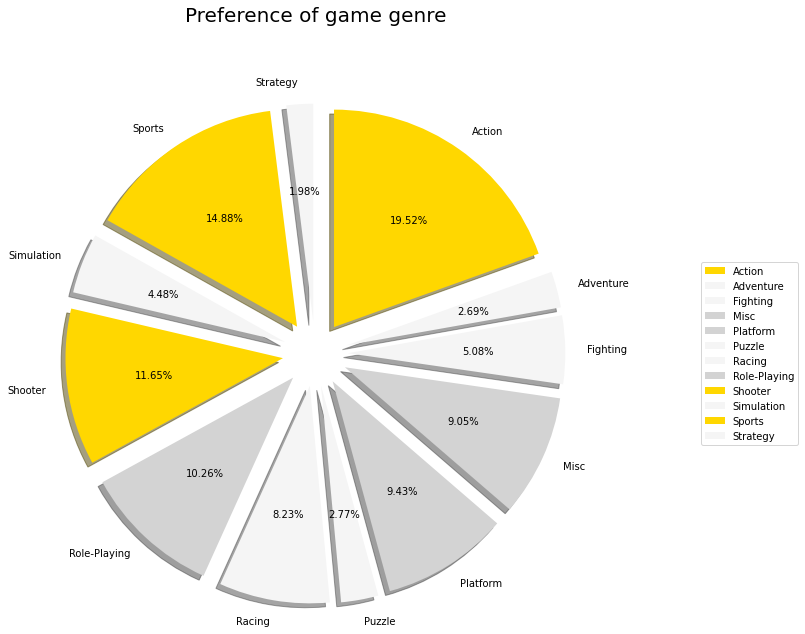

In [ ]:
values = df1['Percentage']
labels = df1['Genre']
explode = [0.15]*12

color = ['gold', 'whitesmoke', 'whitesmoke', 'lightgray', 'lightgray', 'whitesmoke',
         'whitesmoke', 'lightgray' ,'gold', 'whitesmoke', 'gold', 'whitesmoke']
plt.figure(figsize=(10,10))
plt.pie(values, labels=labels, explode=explode, autopct='%.2f%%', shadow=True,
        colors=color,  startangle=90, counterclock=False)
plt.title('Preference of game genre', fontsize=20, position=(0.5, 1.0+0.1))
plt.legend(labels, loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1))
plt.show()

* 장르별로 보면 **Action장르의 시장이 가장 큰 것**을 알 수 있다.  

**결과**  
전체적인 선호도는 Action, Sports, Shooter이다.

---

## **지역에 따라서 선호하는 게임 장르가 있을까?**

H0 = 지역에 따라 선호하는 게임 장르는 없다.  
H1 = 지역에 따라 선호하는 게임 장르가 있다.

 -> 결론: H1 채택. 지역에 따라 선호하는 게임 장르가 있다.

In [ ]:
# 데이터 간 분포에 연관성이 있는지 확인하는 가설검정으로 'two sample chi-squared test'를 진행한다.

In [ ]:
# 검증을 위해 필요한 feature만 가져와서 tidy data로 변환
df0 = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales','Total_Sales']]
df_tidy = df1.melt(id_vars='Genre', value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales','Total_Sales'])


# crosstab으로 dataframe 변경
df_cr = pd.crosstab(df_tidy['variable'], df_tidy['Genre'], values=df_tidy['value'], aggfunc=sum)

In [ ]:
# 카이제곱검정 실행
from scipy.stats import chi2_contingency

chi2 = chi2_contingency(df_cr)
# chi2      # p-value = 2.647817402235075e-118     ->     p-value 값이 0.05보다 작은 값이 도출됨.
# 즉, H0 기각. H1 채택함 -> 결론: 지역에 따라 선호하는 게임 장르가 있음. 

In [ ]:
# 시각화를 위한 dataframe 추출 및 변형

df0 = pd.crosstab(index=df_tidy.Genre, columns=df_tidy.variable, values=df_tidy.value, aggfunc=sum).reset_index()

<BarContainer object of 12 artists>

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


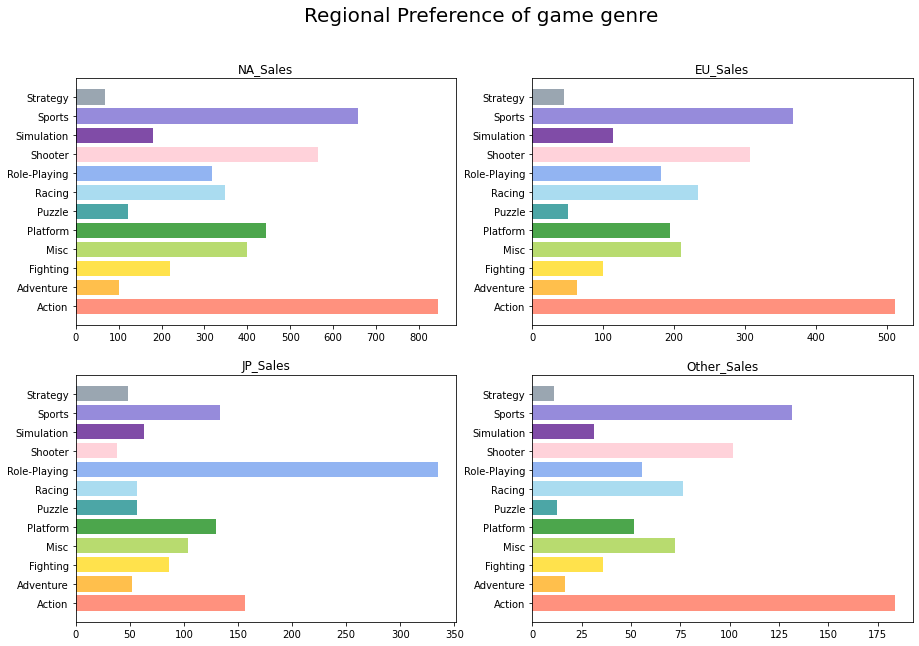

In [ ]:
# 시각화 표현
fig, axs = plt.subplots(2,2, figsize=(15,10))
colors = ['tomato', 'orange', 'gold', 'yellowgreen', 'green', 'teal',
         'skyblue', 'cornflowerblue' ,'pink', 'indigo', 'slateblue', 'slategrey']
          
fig.suptitle('Regional Preference of game genre', fontsize=20)

axs[0,0].set_title('NA_Sales')
axs[0,0].barh(df0['Genre'], df0['NA_Sales'], color=colors, alpha=0.7)

axs[0,1].set_title('EU_Sales')
axs[0,1].barh(df0['Genre'], df0['EU_Sales'], color=colors, alpha=0.7)

axs[1,0].set_title('JP_Sales')
axs[1,0].barh(df0['Genre'], df0['JP_Sales'], color=colors, alpha=0.7)

axs[1,1].set_title('Other_Sales')
axs[1,1].barh(df0['Genre'], df0['Other_Sales'], color=colors, alpha=0.7)

시각화 결과
* 북미, 유럽, 그 외 국가에서 선호하는 게임장르 : Action, Sports, Shooter
* 일본에서 선호하는 게임 장르 : Role-Playing, Action, Sports

전체적으로 선호도가 높은 장르는 Action, Sports 이다.

---


## **연도별 게임의 트렌드가 있을까?**

In [ ]:
# 필요한 데이터셋 만듬.
df2 = df[['Year', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
df2 = df2.groupby(['Year', 'Genre']).sum().reset_index()
df2['Total_Sales'] = df2['NA_Sales'] + df2['EU_Sales'] + df2['JP_Sales'] + df2['Other_Sales']
df2 = df2.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)

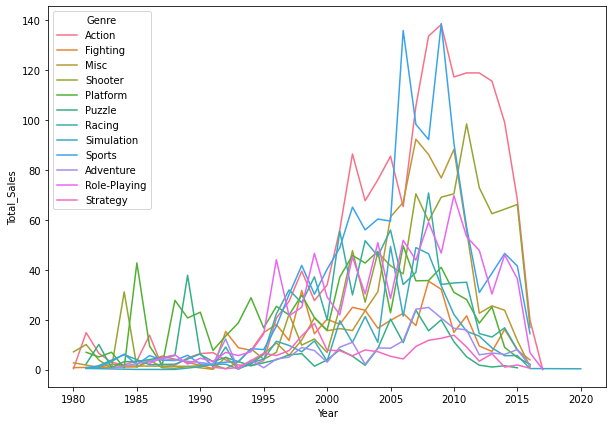

In [ ]:
# 시각화

# Sales 값이 많아서 확인이 잘 안된다.
# 2000년대부터 게임시장이 활황이고, 2008년쯤 기점으로 하락세로 접어드는 것을 확인할 수 있다.
f , ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=df2, x='Year', y='Total_Sales', hue='Genre')

확인이 어려우니 연대별로 나눠서 확인 해봐야겠다.

In [ ]:
filt1 = (df2['Year'] >= 1980) & (df2['Year'] <= 1989)
df80 = df2[filt1]

filt1 = (df2['Year'] >= 1990) & (df2['Year'] <= 1999)
df90 = df2[filt1]

filt1 = (df2['Year'] >= 2000) & (df2['Year'] <= 2009)
df00 = df2[filt1]

filt1 = (df2['Year'] >= 2010) & (df2['Year'] <= 2020)
df10 = df2[filt1]

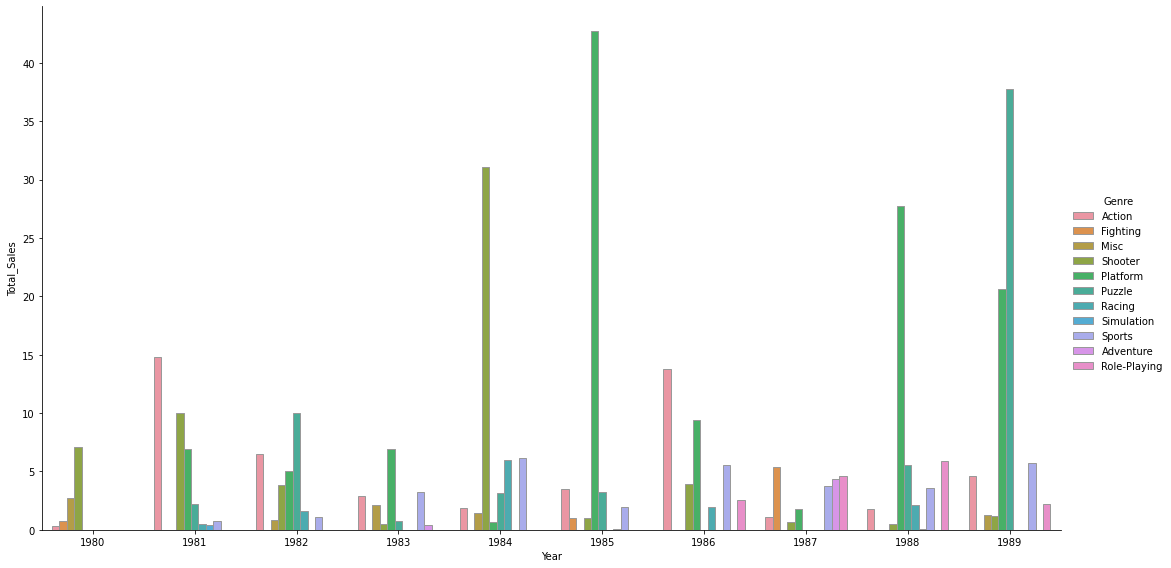

In [ ]:
# 연대별로 나눠서 보고, 선호장르 파악 후 전체적으로 보자.

# 80년대 선호도
sns.catplot(x='Year', y='Total_Sales', hue='Genre', kind='bar',
            data=df80, edgecolor='.6', height=8, aspect=15/8 )

# 80년대는 Shooter, Platform, Puzzle 의 선호도가 가장 높았다.

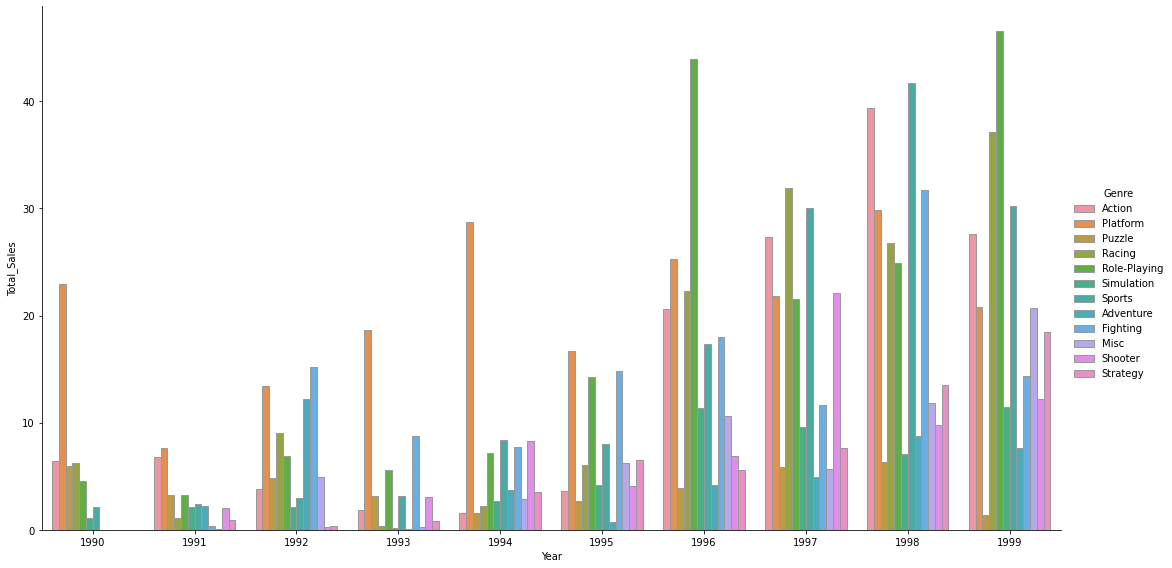

In [ ]:
# 90년대 선호도

sns.catplot(x='Year', y='Total_Sales', hue='Genre', kind='bar',
            data=df90, edgecolor='.6', height=8, aspect=15/8 )

# 90년대는 Role-Playing, Simulation, Sports의 선호도가 높았다.
# 또한, Racing 역시 점진적으로 선호도가 높아지고 있었다.

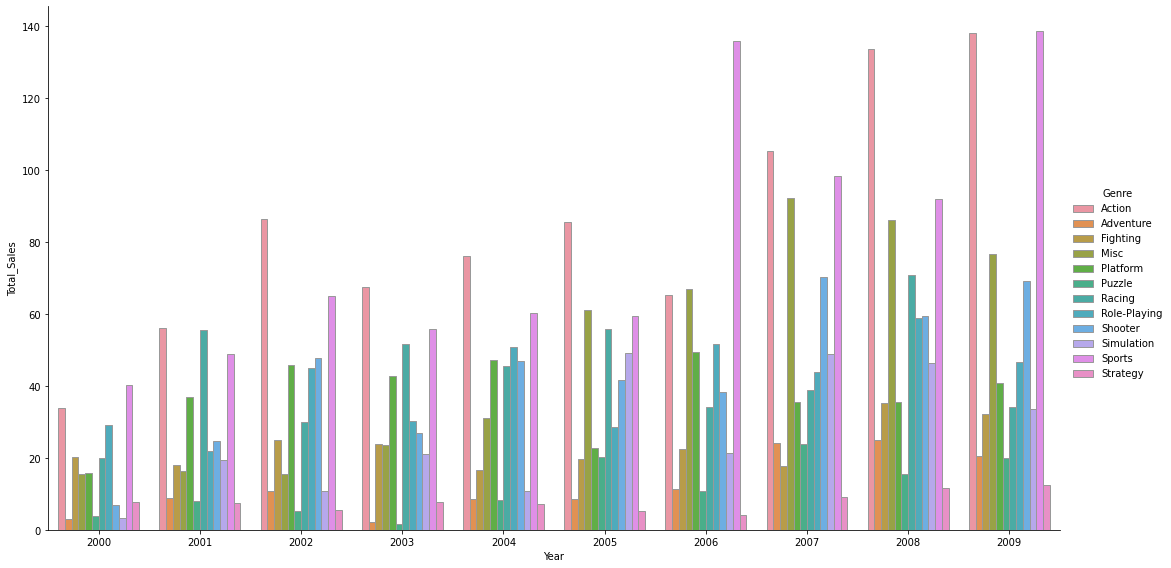

In [ ]:
# 00년대 선호도

sns.catplot(x='Year', y='Total_Sales', hue='Genre', kind='bar',
            data=df00, edgecolor='.6', height=8, aspect=15/8 )

# 00년대에는 Action, Sports 의 선호도가 높았다.

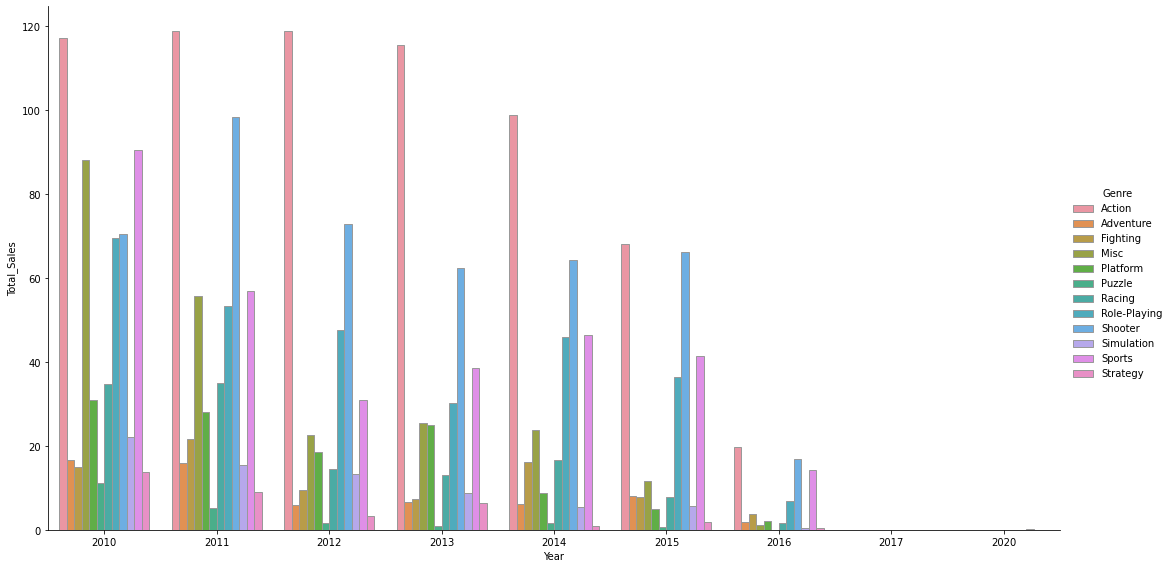

In [ ]:
# 10년대 선호도

sns.catplot(x='Year', y='Total_Sales', hue='Genre', kind='bar',
            data=df10, edgecolor='.6', height=8, aspect=15/8 )

# 전체적으로 하락 추세이나, Action, Shooter의 선호도가 높았다.

**결론**
* 전반적인 하락 추세이지만, 연대별로 장르별 선호도는 있다.

80년대 : Shooter, Platform  
90년대 : Role-Playing, Simulation, Action  
00년대 : Action, Sports   
10년대 : Action, Shooter  

최근 데이터 추이로 보면 Action, Shooter 장르가 좋아보인다.

---

## **출고량이 높은 게임에 대한 분석 및 시각화 프로세스**

지금까지의 분석으로 봤을 때, Action, Shooter, Sports에 대한 선호도가 높았다.  
또한 연도별로 게임의 트랜드가 변화하기 때문에, 최근의 10년간의 데이터에 한정해서 출고량이 높은 게임을 확인해 분석하고자 한다.

**[분석 조건]**  
Gener = Action, Shooter, Sports  
Year = 10년간 데이터

In [ ]:
# 필요한 데이터셋 추출
filt = (df['Genre'] == 'Action') | (df['Genre'] == 'Shooter') | (df['Genre'] == 'Sports')
filt0 = df['Year'] >= 2010

i = df[filt]
j = df[filt0]

df_S = pd.merge(i, j, how='inner')

# Total_sales로 정렬 후, 출고량 높은 게임 확인
df_S = df_S.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)\
                .sort_values('Total_Sales', ascending=False).round(2)
df_S.head(20)

,Name,Platform,Year,Genre,Publisher,Total_Sales
500,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,21.39
393,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,14.76
888,Call of Duty: Black Ops,X360,2010,Shooter,Activision,14.64
1311,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,14.24
602,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,14.04
909,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,13.74
2043,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,13.47
1419,Call of Duty: Black Ops,PS3,2010,Shooter,Activision,12.73
268,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,11.99
806,Call of Duty: Ghosts,X360,2013,Shooter,Activision,10.21


In [ ]:
# 게임별로 top10 출고량을 시각화하여 나타냄
# 데이터셋 만들기
df_top10 = df_S.groupby('Name').sum().sort_values('Total_Sales', ascending=False)
df_top10 = df_top10.drop('Year', axis=1).reset_index().rename(columns={'Name' : 'L-Genre'})
df_top10['Percentage'] = round((df_top10['Total_Sales'] / df_top10['Total_Sales'].sum())*100, 2)
df_top10 = df_top10.head(10)
df_top10.loc[:, 'U-Genre'] = ['Grand Theft Auto V', 'Call of Duty', 'Call of Duty' ,'Call of Duty', 'Call of Duty',
                      'Call of Duty', 'Call of Duty', 'FIFA', 'Battlefield', 'FIFA']
df_top10 = df_top10[['U-Genre', 'L-Genre', 'Percentage', 'Total_Sales']]
df_top10

,U-Genre,L-Genre,Percentage,Total_Sales
0,Grand Theft Auto V,Grand Theft Auto V,3.24,46.29
1,Call of Duty,Call of Duty: Modern Warfare 3,2.16,30.84
2,Call of Duty,Call of Duty: Black Ops II,2.08,29.73
3,Call of Duty,Call of Duty: Black Ops,2.06,29.41
4,Call of Duty,Call of Duty: Ghosts,1.92,27.37
5,Call of Duty,Call of Duty: Black Ops 3,1.77,25.30
6,Call of Duty,Call of Duty: Advanced Warfare,1.43,20.36
7,FIFA,FIFA 15,1.32,18.89
8,Battlefield,Battlefield 3,1.22,17.37
9,FIFA,FIFA 16,1.15,16.43


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


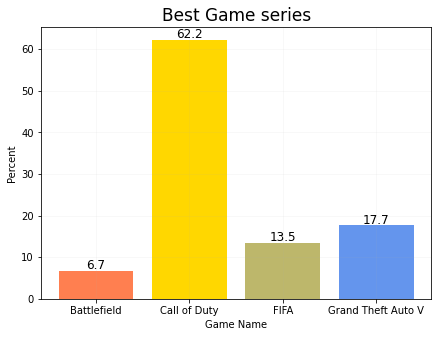

In [ ]:
# 가장 잘 나가는 게임 시리즈를 먼저 파악.
G = df_top10.groupby('U-Genre').sum().drop('Total_Sales', axis=1).reset_index()
G['Percent'] =  round((G['Percentage'] / G['Percentage'].sum())*100, 2)
del G['Percentage']

# 시각화
plt.figure(figsize=(7, 5))
plt.grid(alpha=0.1)
bar = plt.bar(G['U-Genre'], G['Percent'], color=['coral', 'Gold', 'darkkhaki', 'cornflowerblue'])
plt.xlabel('Game Name')
plt.ylabel('Percent')
plt.title('Best Game series',fontsize=17)

for i in range(len(G['U-Genre'])):
    height = G['Percent'][i]
    plt.text(G['U-Genre'][i], height - 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)

게임 중에서 Call of Duty series가 선호도가 굉장히 높은 편이다.  
Call of Duty 중 어떤 series가 출고량이 높은지 확인 해봐야겠다.

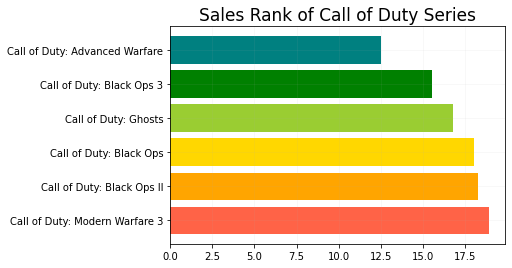

In [ ]:
# Call of Duty 데이터만 가져와서 추출
filt2 = df_top10['L-Genre'].str.contains('Call of Duty')
CoD = df_top10[filt2].drop('Percentage', axis=1)
CoD['Percent'] = round((CoD['Total_Sales'] / CoD['Total_Sales'].sum()) *100, 2)

# 시각화
colors = ['tomato', 'orange', 'gold', 'yellowgreen', 'green', 'teal']
plt.barh(CoD['L-Genre'], CoD['Percent'], color=colors)
plt.grid(alpha=0.1)
plt.title('Sales Rank of Call of Duty Series', fontsize=17)
plt.show()

* Action장르의 시장 비중이 커서 출고량이 가장 많은 게임 역시 Action장르일 거라고 생각했는데, 의외로 Shooter 였다.    
또한, Sport 장르 역시 선호도 면에서 Shooter를 앞섰는데, 최근 10년 데이터만 보니 Shooter가 현저히 좋은 성적을 내고 있는게 보인다.  

* 특히, Call of Duty 시리즈는 어느 하나 할 것 없이 전체적으로 인기가 있다.
---

**결론**
지금까지의 분석 결과로는  
다음 분기에 설계할 게임으로 **Shooter 장르가 수익을 내기 좋아보인다**.


## 플랫폼 분석



새로운 플랫폼이 나오면 그 전 플랫폼은 선호도가 낮아진다.  
그러니 Shooter 장르에서 10년간 가장 많은 선호도를 보인 Call of Duty 시리즈만을 가지고 플랫폼 연도별 변화를 분석해보는 것이 좋을 듯.

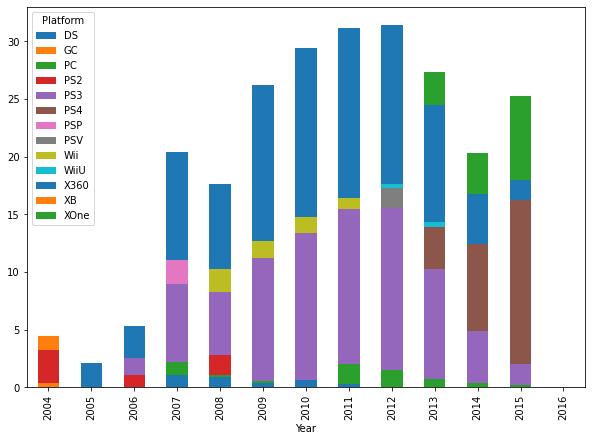

In [ ]:
# 데이터 추출
a = df['Year'] >= 10
b = df['Name'].str.contains('Call of Duty')
df_Pf = pd.merge(df[a], df[b], how='inner').drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1).\
                groupby(['Year','Platform']).sum().reset_index()


#시각화
df_Pf = df_Pf.pivot(index='Year', columns='Platform', values='Total_Sales')
df_Pf.plot.bar(stacked=True, figsize=(10,7))

플랫폼은 **PS4와 XOne을 타겟**으로 하는 것이 수익성이 좋을듯 하다.

---

## **결론**
다음 분기에 설계할 게임은 다음을 타겟으로 한다.  

국가 : NA(북미), EU(유럽)  
장르 : Shooter  
플랫폼 : PS4, XOne  

Shooter 장르에서 Call of Duty의 시리즈가 독보적인 인기를 끌고 있다.  
플랫폼 PS4, XOne을 위주로 Call of Duty의 새로운 시리즈를 다음 분기에 설계해보고자 한다.